# PacBio 2019 alzheimer Sequel2 dataset

This notebook demonstrates the data preprocessing, import and basic vizualization of genes with sashimi plots. 

## Preparation
1) prepare the working directory and download the reference and data
``` bash
    cd /my/working/directory
    # create some subdirectories
    mkdir -p reference alzheimer/flnc alzheimer/aligned alzheimer/pickle tables plots
    
    # download a reference genome (806 MB)
    genome_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/GRCh38.p13.genome.fa.gz'
    wget -P reference/ -O GRCh38.p13.genome.fa.gz ${genome_link} 
    gunzip reference/GRCh38.p13.genome.fa.gz
    
    # download gencode reference annotation (46.2 MB)
    gff='gencode.v36.chr_patch_hapl_scaff.annotation'
    annotation_link= ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/${gff}.gff3.gz
    wget -P reference/ ${annotation_link} 
    
    # sort by chromosome and position
    (zcat ${gff}.gff3.gz| grep ^"#" ; zcat reference/${gff}.gff3.gz|grep -v ^"#"| sort -k1,1 -k4,4n)|bgzip  > reference/${gff}_sorted.gff3.gz
    # create index
    tabix -p gff reference/${gff}_sorted.gff3.gz
    
    # download the isoseq flnc data (4.1 GB)
    isoseq_link='https://downloads.pacbcloud.com/public/dataset/Alzheimer2019_IsoSeq/FullLengthReads/flnc.bam'
    wget -P alzheimer/flnc -O alzheimer2019_isoseq_flnc.bam ${isoseq_link} 
```

2) align the isoseq data to the reference genome using minimap2.
If the pacbio isoseq3 workflow is [installed](https://github.com/PacificBiosciences/IsoSeq_SA3nUP/wiki/Tutorial:-Installing-and-Running-Iso-Seq-3-using-Conda) you can use the pacbio version of minimap2 as follows:

``` sh
    #activate the isoseq3 environement (assuming it is called pacbio)
    conda activate pacbio
    n_threads=60
    sample='alzheimer2019_isoseq'
    ref='reference/GRCh38.p13.genome.fa'
    pbmm2 align ${ref} alzheimer/flnc/${sample}_flnc.bam alzheimer/aligned/${sample}_aligned.sorted.bam --preset ISOSEQ --sort -j $n_threads 
```



## Data import

In [1]:
from  isotools import Transcriptome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
sample='alzheimer2019_isoseq'
bam=f'alzheimer/aligned/{sample}_aligned.sorted.bam'
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'



In [3]:

try:
    #try to restore previously prepared data
    isoseq=Transcriptome(f'alzheimer/pickle/{sample}_isotools.pkl')
except FileNotFoundError:
    try:
        #restore the reference (2-3 minutes)
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        #import the reference from gff3 (2-3 minutes)
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz') 
        # save the reference, so it it can be restored for other analysis
        isoseq.save_reference(anno+'.isotools.pkl') 
    # import the long read data and compare to reference (only one sample for this dataset, takes 30-40 minutes)
    isoseq.add_sample_from_bam(bam, sample_name='alzheimer_1', group='alzheimer') 
    # compute QC metrics for all transcripts
    isoseq.add_biases(genome) #takes 15-20 min
    # update the index for fast gene access by name/id
    isoseq.make_index()
    # save the current data
    isoseq.save(f'alzheimer/pickle/{sample}_isotools.pkl')


## Data exploration

In [4]:
#access of genes by Name
print(isoseq['MAPT'])

Gene MAPT chr17:45894550-46028334(+), 16 reference transcripts, 267 expressed transcripts


## Data vizualization
We depict the MAPT gene with its two major exon skipping events as sashimi plot.

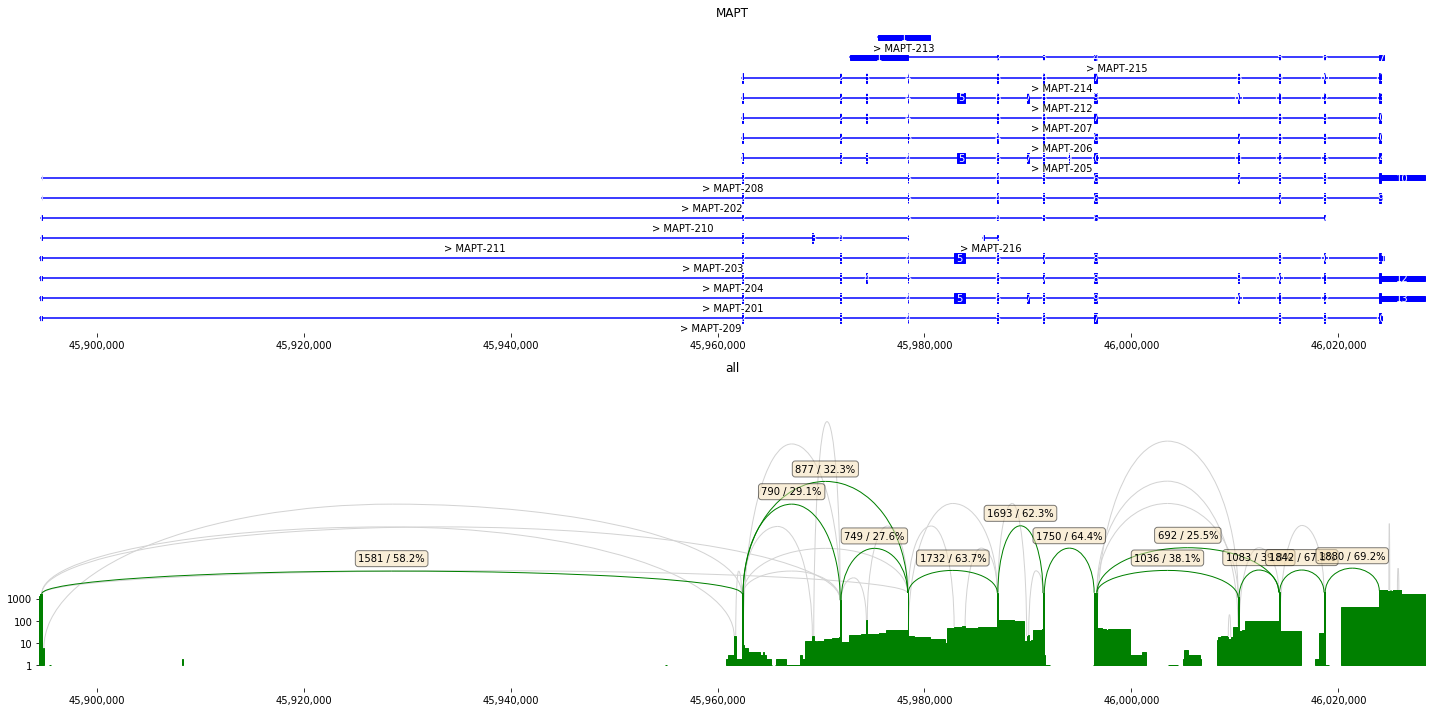

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
fig,axs=isoseq['MAPT'].sashimi_figure()
fig.tight_layout()